In [4]:
import krstc_utils as kutils
import pandas as pd
import numpy as np
from pygama.flow import DataGroup
import matplotlib.pyplot as plt
import numpy as np
import json

colors = {
    'bkg':'tab:gray',
    'kry':'tab:blue',
    'decay':'tab:orange',
    'rb83':'tab:green',
    'study':'tab:red'
}

In [2]:
krtscDB = DataGroup('/global/cfs/cdirs/legend/software/KrSTC/data/krstc.json', load=True)
runDB = krtscDB.runDB
lh5_dir = krtscDB.lh5_dir
dsp_list = lh5_dir + krtscDB.fileDB['dsp_path'] + '/' + krtscDB.fileDB['dsp_file']
BEGINNING_CYCLE = 2019

In [5]:
# read skip_cycle_dict.json to skip cycles
with open('skip_cycle_dict.json', 'r') as f:
    skip_cycle_dict = json.load(f)
skip_cycle_dict

{'77': [3377],
 '92': [3876, 3877],
 '71': [3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303]}

# count rates

In [7]:
#runs = np.arange(57,59+1).tolist()
runs = np.arange(94,96+1).tolist()
# delete 77
#runs.remove(77)
params = [['trapEmax','timestamp']]

count_rate_df = pd.DataFrame(columns=['run', 'cycle', 'runtime_s', 'count_rate', 'start_time', 'end_time', 'runtype', 'fileDB_startTime'])

ecal_range = [11, 32]


for run in runs:
    print(run)
    # if run==92:
    #     df, runtype = kutils.load_dsp(run=run, params=params, verbose=False, skip_cycles=[3876,3877])
    # else:
    #     df, runtype = kutils.load_dsp(run=run, params=params, verbose=False)

    skip_cycles = None
    if skip_cycle_dict.__contains__(str(run)):
        skip_cycles = skip_cycle_dict[str(run)]

    df, runtype, description = kutils.load_dsp(run=run, params=params, verbose=False, skip_cycles=skip_cycles)


    cycles = df.cycle.unique()
    runtimes = df.runtime_s.unique()


    for cycle, runtime in zip(cycles, runtimes):
        dfc = df[df.cycle==cycle]
        start_time = dfc.timestamp.min()
        end_time = dfc.timestamp.max()

        dfc = dfc[(dfc.trapEmax_cal_keV>ecal_range[0]) & (dfc.trapEmax_cal_keV<ecal_range[1])]


        count_rate = len(dfc)/runtime
        count_rate_err = np.sqrt(len(dfc))/runtime

        d = {'run': run, 'cycle': cycle, 'runtime_s': runtime, 'count_rate': count_rate, 'count_rate_err':count_rate_err, 'start_time': start_time, 'end_time': end_time, 'runtype': runtype, 'fileDB_startTime': krtscDB.fileDB.iloc[cycle-BEGINNING_CYCLE]['startTime']}

        count_rate_df = pd.concat([count_rate_df, pd.DataFrame([d])])

# convert fileDB_startTime to datetime
count_rate_df['fileDB_startDate'] = pd.to_datetime(count_rate_df['fileDB_startTime'], unit='s')

# date diff between each row
count_rate_df['date_diff'] = count_rate_df['fileDB_startDate'].diff().dt.seconds

count_rate_df

94
95
96


,run,cycle,runtime_s,count_rate,start_time,end_time,runtype,fileDB_startTime,count_rate_err,fileDB_startDate,date_diff
0,94,3932,1499.591322,2.722742,1074590,149959132167,bkg,1.684614e+09,0.042611,2023-05-20 20:15:52,NaN
0,94,3933,1498.128616,2.720060,6677426,149812861630,bkg,1.684615e+09,0.042610,2023-05-20 20:40:52,1500.0
0,94,3934,1399.613658,2.685741,3126612,139961365802,bkg,1.684617e+09,0.043805,2023-05-20 21:05:52,1500.0
0,95,3935,1498.563480,5.075527,3307779,149856348044,kry,1.684618e+09,0.058197,2023-05-20 21:29:14,1402.0
0,95,3936,1498.617882,4.203206,7283519,149861788172,kry,1.684620e+09,0.052960,2023-05-20 21:54:14,1500.0
...,...,...,...,...,...,...,...,...,...,...,...
0,96,4053,1499.036251,3.053295,3398144,149903625071,decay,1.684790e+09,0.045131,2023-05-22 21:17:47,1500.0
0,96,4054,1499.836341,3.126341,9517172,149983634062,decay,1.684792e+09,0.045656,2023-05-22 21:42:48,1501.0
0,96,4055,1498.983874,3.031387,3160378,149898387353,decay,1.684793e+09,0.044970,2023-05-22 22:07:48,1500.0
0,96,4056,1499.317685,2.916660,3202168,149931768503,decay,1.684795e+09,0.044106,2023-05-22 22:32:49,1501.0


Text(0.5, 1.0, 'count/s, ecal_range: [11, 32]keV \nruns:[94 95 96]')

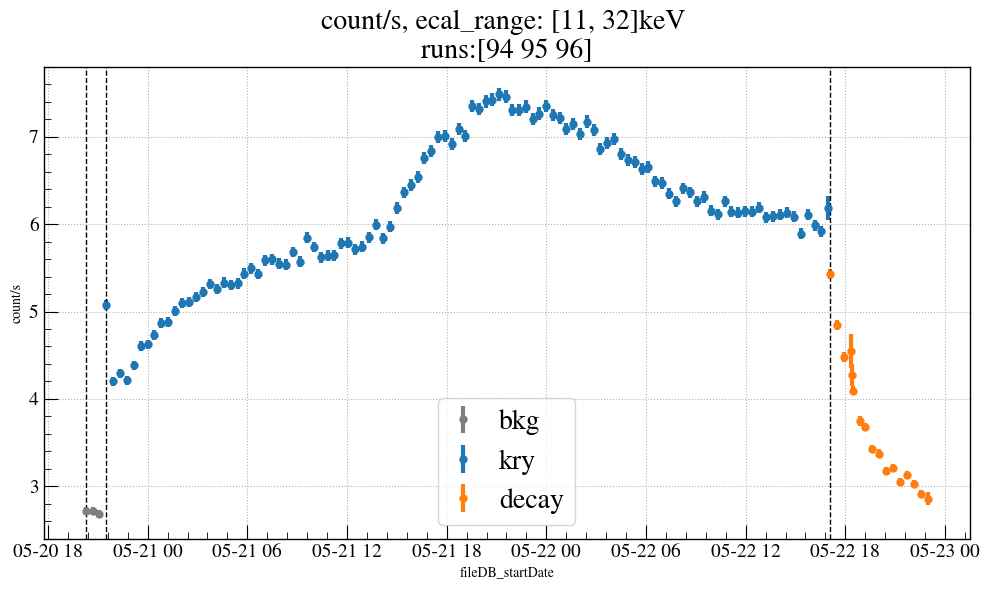

In [8]:
# plot count rate vs fileDB_startDate with each runtype with different color
fig, ax = plt.subplots(figsize=(10,6))
for runtype in count_rate_df.runtype.unique():
    df = count_rate_df[count_rate_df.runtype==runtype]

    ax.errorbar(df.fileDB_startDate, df.count_rate, df.count_rate_err, label=runtype, marker='o', linestyle='none', color=colors[runtype], markersize=5)
    #ax.plot(df.fileDB_startDate, df.count_rate, label=runtype, marker='o', linestyle='none', color=colors[runtype], markersize=5)
    

# plot vertical line at the start of the first cycle of each run
for run in count_rate_df.run.unique():
    df = count_rate_df[count_rate_df.run==run]
    ax.axvline(df.fileDB_startDate.min(), color='k', linestyle='--', lw=1)

ax.set_xlabel('fileDB_startDate')
ax.set_ylabel('count/s')
ax.legend()
plt.title('count/s, ecal_range: ' + str(ecal_range)+ 'keV \nruns:'+str(count_rate_df.run.unique()))
#plt.ylim(0,20)

# baseline

In [16]:
runs = np.arange(89,93+1).tolist()
params = [['trapEmax','timestamp', 'bl']]

dff = pd.DataFrame(columns=['run', 'cycle', 'runtime_s', 'bl','bl_err', 'start_time', 'end_time', 'runtype', 'fileDB_startTime'])



for run in runs:
    skip_cycles = None
    if skip_cycle_dict.__contains__(str(run)):
        skip_cycles = skip_cycle_dict[str(run)]

    df, runtype, description = kutils.load_dsp(run=run, params=params, verbose=False, skip_cycles=skip_cycles)

    cycles = df.cycle.unique()
    runtimes = df.runtime_s.unique()


    for cycle, runtime in zip(cycles, runtimes):
        dfc = df[df.cycle==cycle]
        start_time = dfc.timestamp.min()
        end_time = dfc.timestamp.max()


        #dfc = dfc[(dfc.trapEmax_cal_keV>5) & (dfc.trapEmax_cal_keV<32)]


        bl = dfc.bl.mean()
        bl_err = np.sqrt(len(dfc))/runtime
        #bl_intercept = dfc.bl_intercept.mean()

        d = {'run': run, 'cycle': cycle, 'runtime_s': runtime, 'bl': bl, 'bl_err':bl_err, 'start_time': start_time, 'end_time': end_time, 'runtype': runtype, 'fileDB_startTime': krtscDB.fileDB.iloc[cycle-BEGINNING_CYCLE]['startTime']}

        dff = pd.concat([dff, pd.DataFrame([d])])

# convert fileDB_startTime to datetime
dff['fileDB_startDate'] = pd.to_datetime(dff['fileDB_startTime'], unit='s')

# date diff between each row
dff['date_diff'] = dff['fileDB_startDate'].diff().dt.seconds





dff

,run,cycle,runtime_s,bl,bl_err,start_time,end_time,runtype,fileDB_startTime,fileDB_startDate,date_diff
0,89,3805,1352.019834,33815.996094,0.229451,2490377,135201983417,kry,1.683828e+09,2023-05-11 17:56:52,NaN
0,89,3806,1499.925182,33818.644531,0.217103,3464783,149992518192,kry,1.683829e+09,2023-05-11 18:19:25,1353.0
0,89,3807,1499.907044,33818.917969,0.216848,3495453,149990704368,kry,1.683831e+09,2023-05-11 18:44:26,1501.0
0,89,3808,1498.467342,33816.855469,0.216827,3356476,149846734243,kry,1.683832e+09,2023-05-11 19:09:27,1501.0
0,89,3809,1499.939001,33816.738281,0.216812,7165455,149993900124,kry,1.683834e+09,2023-05-11 19:34:28,1501.0
...,...,...,...,...,...,...,...,...,...,...,...
0,93,3927,1498.545069,33819.648438,0.218390,2995257,149854506896,decay,1.684076e+09,2023-05-14 14:48:39,1502.0
0,93,3928,1499.111564,33824.671875,0.218251,9508253,149911156405,decay,1.684077e+09,2023-05-14 15:13:39,1500.0
0,93,3929,1498.654435,33822.761719,0.217860,4241194,149865443544,decay,1.684079e+09,2023-05-14 15:38:39,1500.0
0,93,3930,1498.971716,33829.437500,0.218254,9874994,149897171596,decay,1.684080e+09,2023-05-14 16:03:40,1501.0


(33700.0, 33850.0)

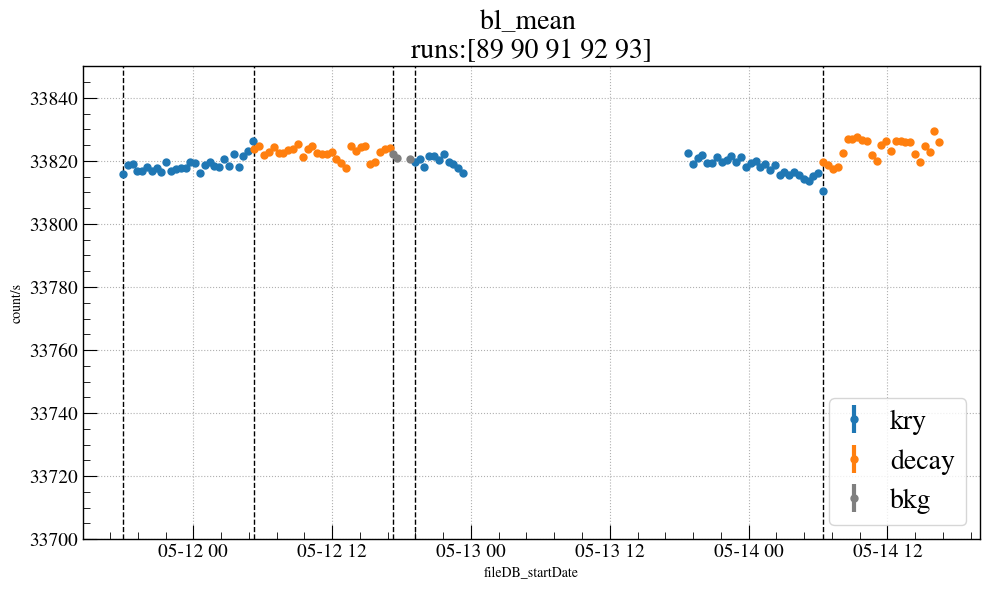

In [17]:
#plot it
# plot count rate vs fileDB_startDate with each runtype with different color
fig, ax = plt.subplots(figsize=(10,6))
for runtype in dff.runtype.unique():
    d = dff[dff.runtype==runtype]
    ax.errorbar(d.fileDB_startDate, d.bl, d.bl_err, label=runtype, marker='o', linestyle='none', color=colors[runtype],markersize=5)

# plot vertical line at the start of the first cycle of each run
for run in dff.run.unique():
    d = dff[dff.run==run]
    ax.axvline(d.fileDB_startDate.min(), color='k', linestyle='--', lw=1)

ax.set_xlabel('fileDB_startDate')
ax.set_ylabel('count/s')
ax.legend()
plt.title('bl_mean \nruns:'+str(dff.run.unique()))
plt.ylim(33700,33850)